# Dependencias

In [32]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from pathlib import Path
from keras.layers import *
from keras.models import *

In [4]:
path = Path.cwd().parent / 'data' / 'UTKFace'
files = os.listdir(path)
size = len(files)
print("Total muestras:", size)
print(f"Ejemplo de archivo: {files[0]}, Edad: {100}, Género: {0}")


Total muestras: 23708
Ejemplo de archivo: 100_0_0_20170112213500903.jpg.chip.jpg, Edad: 100, Género: 0


In [5]:
images = []	# Lista de imágenes
ages = []     # Lista de edades
genders = []   # Lista de géneros

for file in files:
    image = cv2.imread(str(path / file), 0)
    image = cv2.resize(image, dsize=(64, 64))
    image = image.reshape((image.shape[0], image.shape[1], 1))
    images.append(image)
    split_var = file.split('_')
    ages.append(split_var[0])
    genders.append(int(split_var[1]))

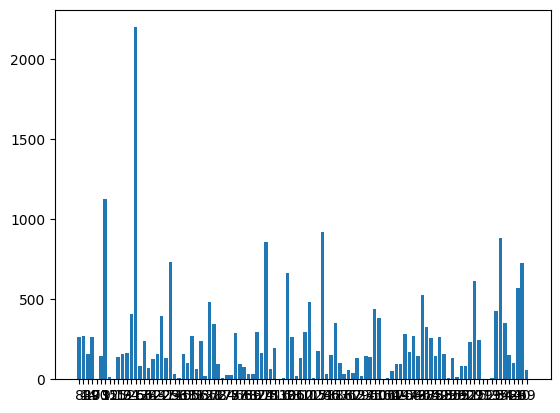

Max value: 99


In [6]:
x_ages = list(set(ages))
y_ages = [ages.count(i) for i in x_ages]
plt.bar(x_ages, y_ages)
plt.show()
print("Max value:", max(ages))

Género: 1 Age: 21


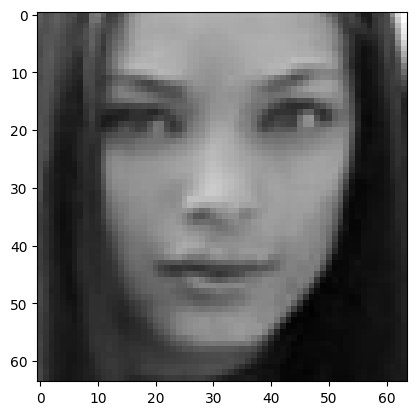

In [7]:
def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()

idx = np.random.randint(0, len(images))
sample = images[idx]
print("Género:", genders[idx], "Age:", ages[idx])
display(sample)


In [8]:
def age_group(age):
    if age >= 0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4

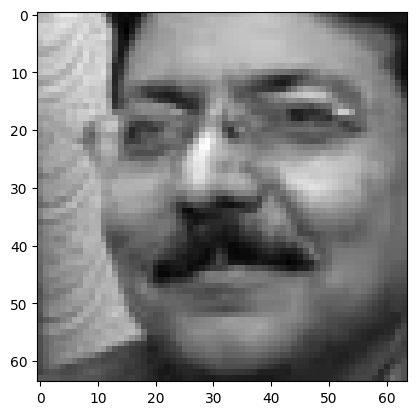

In [9]:
#preprocesamiento
target = np.zeros((size,2), dtype='float32')
features = np.zeros((size, sample.shape[0], sample.shape[1], 1), dtype='float32')
for i in range(size):
    target[i,0] = age_group(int(ages[i])) / 4
    target [i,1] = int(genders[i])
    features[i] = images[i]

features = features / 255
display(features[np.random.randint(0, len(features))])

In [25]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=True)
print("Muestras de Entrenamiento:", x_train.shape[0])
print("Muestras de Testing:", x_test.shape[0])
y_test

Muestras de Entrenamiento: 18966
Muestras de Testing: 4742


array([[0.75, 0.  ],
       [0.5 , 0.  ],
       [0.75, 1.  ],
       ...,
       [0.75, 0.  ],
       [0.5 , 0.  ],
       [0.75, 1.  ]], dtype=float32)

In [11]:
print("Shape de imagen:", sample.shape)

Shape de imagen: (64, 64, 1)


In [12]:
inputs = Input(shape=(sample.shape[0], sample.shape[1], 1))
conv1 = Conv2D(32, kernel_size=(3,3), activation='relu')(inputs)
conv2 = Conv2D(64, kernel_size=(3,3), activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2,2))(conv2)
conv3 = Conv2D(128, kernel_size=(3,3), activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2,2))(conv3)
x = Dropout(0.25)(pool2)
flat = Flatten()(x)

dropout = Dropout(0.5)
age_model = Dense(128, activation='relu')(flat)
age_model = dropout(age_model)
age_model = Dense(64, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(32, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(1, activation='relu')(age_model)

dropout = Dropout(0.5)
gender_model = Dense(128, activation='relu')(flat)
gender_model = dropout(gender_model)
gender_model = Dense(64, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(32, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(16, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(8, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(1, activation='sigmoid')(gender_model)


In [13]:
model = Model(inputs=inputs, outputs=[age_model, gender_model])
model.compile(optimizer='adam', loss=['mse', 'binary_crossentropy'], metrics=['accuracy'])

In [14]:
# Entrenamiento
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 62, 62, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 60, 60, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 30, 30, 64)   0           ['conv2d_1[0][0]']               
                                                                                              

In [58]:
history = model.fit(x_train, [y_train[:,0], y_train[:,1]], validation_data=(x_test, [y_test[:,0], y_test[:,1]]), epochs=25, batch_size=128, shuffle=True)

Epoch 1/25
149/149 [==============================] - 354s 2s/step - loss: 0.8271 - dense_13_loss: 0.1335 - dense_19_loss: 0.6936 - dense_13_accuracy: 0.0119 - dense_19_accuracy: 0.5165 - val_loss: 0.7324 - val_dense_13_loss: 0.0403 - val_dense_19_loss: 0.6921 - val_dense_13_accuracy: 0.0306 - val_dense_19_accuracy: 0.5205
Epoch 2/25
149/149 [==============================] - 349s 2s/step - loss: 0.7272 - dense_13_loss: 0.0516 - dense_19_loss: 0.6757 - dense_13_accuracy: 0.0183 - dense_19_accuracy: 0.5860 - val_loss: 0.6381 - val_dense_13_loss: 0.0269 - val_dense_19_loss: 0.6112 - val_dense_13_accuracy: 0.0295 - val_dense_19_accuracy: 0.7655
Epoch 3/25
149/149 [==============================] - 348s 2s/step - loss: 0.6211 - dense_13_loss: 0.0444 - dense_19_loss: 0.5767 - dense_13_accuracy: 0.0202 - dense_19_accuracy: 0.7222 - val_loss: 0.4611 - val_dense_13_loss: 0.0267 - val_dense_19_loss: 0.4344 - val_dense_13_accuracy: 0.0318 - val_dense_19_accuracy: 0.8258
Epoch 4/25
149/149 [=====

In [59]:
model.save('data.h5')

In [15]:
model = load_model('data.h5')


In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Precisión del modelo')
plt.ylabel('precisión')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [18]:
def get_age(distr):
    distr = distr*4
    if distr >= 0.65 and distr <= 1.4:
        return "0-18"
    if distr >= 1.65 and distr <= 2.4:
        return "19-30"
    if distr >= 2.65 and distr <= 3.4:
        return "31-80"
    if distr >= 3.65 and distr <= 4.4:
        return "80 +"
    return "Unknown"

def get_gender(prob):
    return "Male" if prob < 0.5 else "Female"

def get_result(sample):
    sample = sample/255
    val = model.predict(np.array([sample]))
    age = get_age(val[0])
    gender = get_gender(val[1])
    print("Valores:", val, "\nPredicción de Género:", gender, "Predicción de edad:", age)
    

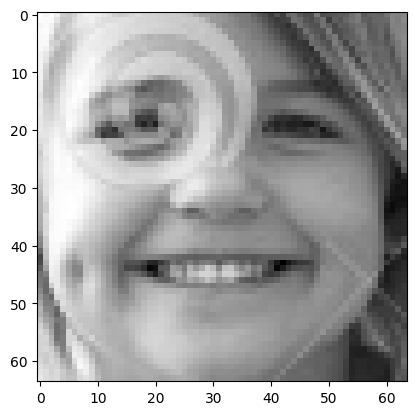

Género Actual: Female Edad: 4
1/1 [==============================] - 0s 149ms/step
Valores: [array([[0.46679446]], dtype=float32), array([[0.2669575]], dtype=float32)] 
Predicción de Género: Male Predicción de edad: 19-30


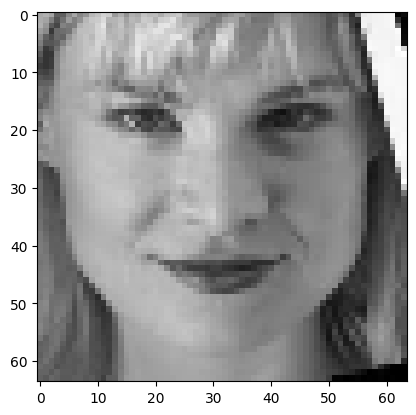

Género Actual: Female Edad: 27
1/1 [==============================] - 0s 39ms/step
Valores: [array([[0.47808647]], dtype=float32), array([[0.99946076]], dtype=float32)] 
Predicción de Género: Female Predicción de edad: 19-30


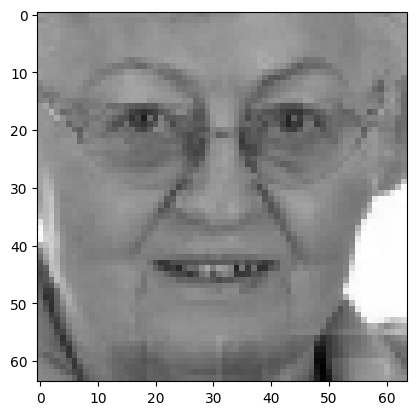

Género Actual: Female Edad: 85
1/1 [==============================] - 0s 47ms/step
Valores: [array([[0.75546265]], dtype=float32), array([[0.9837445]], dtype=float32)] 
Predicción de Género: Female Predicción de edad: 31-80


In [27]:
#Examples
indexes = [np.random.randint(0, len(images)) for _ in range(3)]
for i in indexes:
    sample = images[i]
    display(sample)
    print("Género Actual:", get_gender(genders[i]), "Edad:", ages[i])
    result = get_result(sample)


# Métricas a utilizar
- Precisión equilibrada
- Diferencia de probabilidades
- Coeficiente de discriminación
- Tasa de falsos positivos
- Tasa de falsos negativos

In [62]:
#Obtain predictions
predictions = model.predict(x_test)
threshold = 0.5
y_pred_labels = np.where(predictions[1] > threshold, 1, 0)

149/149 [==============================] - 20s 136ms/step
Predicciones: [[0]
 [0]
 [1]
 ...
 [0]
 [0]
 [1]]


In [53]:
# calculating the variables for the metrics 

male_tp, male_fp, male_tn, male_fn = 0, 0, 0, 0
fem_tp, fem_fp, fem_tn, fem_fn= 0, 0, 0, 0

for i,gtest in enumerate(y_test):
    if gtest[1] == 0:
        
        if y_pred_labels[i][0] == 0:
            male_tp+=1
            fem_tn+=1
        else:
            male_fn+=1
            fem_fp+=1
    else:
        if y_pred_labels[i][0] == 1:
            fem_tp+=1
            male_tn+=1
        else:
            fem_fn+=1
            male_fp+=1



In [64]:
#True Positive Rate
male_tpr = male_tp/(male_tp+male_fn)
fem_tpr = fem_tp/(fem_tp+fem_fn)

#False Positive Rate
male_fpr = male_fp/(male_fp+male_tn)
fem_fpr = fem_fp/(fem_fp+fem_tn)

#Equal Accuracy
eq = (male_tpr+fem_tpr)/2

#Difference of Probabilities
positive_prob = np.array(predictions)[:, 0]
dp = abs(positive_prob[0]-(1-positive_prob[0]))

#Discrimination Coefficient
#dc = 

print(male_tpr, fem_tpr, male_fpr, fem_fpr, eq, dp)


0.951417004048583 0.9102112676056338 0.0897887323943662 0.048582995951417005 0.9308141358271084 [0.46426415]
